# Tutorial: PyTorch Transfer Learning Debugger

_Source_: [Adapted: Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

**_Purpose_: _To provide an interactive debugging experience for PyTorch code, enabling users to diagnose issues related to weight updates during training, as well as to address problems with slow or unstable convergence._**

----
# Getting Started

1. Clone the repository
2. Download the data from the [original tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
3. Place the data in the directory `./data/`.


----
```
: zachcolinwolpe@gmail.com
: 09.12.24
```
----

In [1]:
# License: BSD
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm import tqdm
import matplotlib.pyplot as plt

cudnn.benchmark = True
plt.ion()   # interactive mode

/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/lib-dynload/../

In [14]:
from src.pytorch_transfer_learning_debugger.torch_debugger import (torch_debugger)
print(torch_debugger)

<class 'src.pytorch_transfer_learning_debugger.torch_debugger.torch_debugger'>


----
# 01. Prepare & Visualise Data
---

Download the data from tutorial repo:

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.


/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/lib-dynload/../

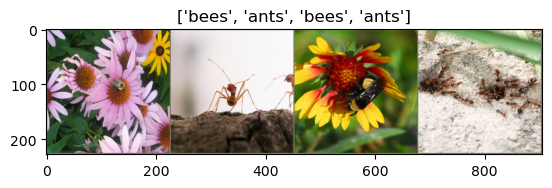

In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# configure dataloader
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

----
# 02. Helpers
----

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

---
# 03. Training Code
----

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, debug_mode=True, granular_logging=False):
    """
    ------------------------------------------------------------------------------------
    Training code with extra debugging.

    if <debug_mode == True>:
        
        Activate Debug Mode:
            - Track model weights to ensure they are being updated.
            - Note: only weights with `requires_grad==True` are tracked.

            Designed to populate the <torch_debugger._track_weights (dict)> for downstream analysis.
            


        if <granular_logging == TRUE>:
            - EXIT run after 1 cycle in the data loader to avoid excessive logging.
            - log each stage of the computational graph:

            Stages:
                > Verifying optimizer
                > Zeroing gradients
                > Moving data to device
                > Forward pass - get predictions class - compute loss
                > Compute gradient - Optimizer take step
                > 

    Return
    ------

        : torch_debugger_inst (torch debugger instance)
        : model (model instance)
    
    ------------------------------------------------------------------------------------
    """
    
    since = time.time()

    # initial torch_debugger ------------------------------------>>
    torch_debugger_inst = None
    if debug_mode:
        torch_debugger_inst = torch_debugger(enable_log_stage=granular_logging)
        torch_debugger_inst.log_stage('Verifying optimizer')
        torch_debugger_inst.verify_optimizer_state(optimizer)
        
        # Store the initial weights - to test whether the weights are updating.
        torch_debugger_inst.initial_model_weights_state = model.state_dict().copy()

        # check gradients - expected to not be null
        NULL_GRADIENTS = torch_debugger_inst.check_gradients_are_not_null(model.named_parameters())
        print('NULL_GRADIENTS:  ', NULL_GRADIENTS)

        # log avg grads
        if granular_logging:
            avg_grads, layers = torch_debugger_inst.check_gradient_flow(model.named_parameters())
            print('avg_grads, layers: ')
            print(avg_grads, layers)
            # torch_debugger_inst.log_weights_mean(model.named_parameters())
    # initial torch_debugger ------------------------------------>>

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0


        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode            
                else:
                    model.eval()   # Set model to evaluate mode
                
                if debug_mode:
                    torch_debugger_inst.log_predefined_message(progress_str=phase, message_id=0)

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:

                    if debug_mode:
                        torch_debugger_inst.log_stage('Moving data to device')
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    if debug_mode:
                        torch_debugger_inst.log_stage('Zeroing gradients')
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    if debug_mode:
                        torch_debugger_inst.log_stage('Forward pass - get predictions class - compute loss')
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            if debug_mode:
                                torch_debugger_inst.log_stage('Compute gradient - Optimizer take step')
                            loss.backward()
                            optimizer.step()
                            avg_grads, layers = torch_debugger_inst.check_gradient_flow(model.named_parameters())
                            print('avg_grads, layers: ')
                            print(avg_grads, layers)

                            NULL_GRADIENTS = torch_debugger_inst.check_gradients_are_not_null(model.named_parameters())
                            print('NULL_GRADIENTS:  ', NULL_GRADIENTS)  
                   

                            # track weights
                            torch_debugger_inst.track_weights(model.named_parameters())


                    # statistics
                    if debug_mode:
                        torch_debugger_inst.log_stage('Compute running statistics.')
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # if granular logging - EXIT after a single data loader call
                    if granular_logging:
                        # force scheduler to excute early for debugging. This should not happen in a real training run.
                         # Currently not possible to excute - because run will be excited
                        torch_debugger_inst.log_stage('Scheduler step.')    
                        scheduler.step()
                        print('EXIT RUN - GRANULAR DEBUGGING ACTIVE.')
                        return torch_debugger_inst, model
                    
                if phase == 'train': 
                    scheduler.step()
                            
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
        
    
                if debug_mode:
                    torch_debugger_inst.log_stage('Terminate debug run.')
                    return torch_debugger_inst, model
                            
            print()

            

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return torch_debugger_inst, model

----
# 04. Load Model & Config
---

In [37]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Original weights
# INIT_WEIGHT = model_ft.state_dict().copy()
# old_weight = INIT_WEIGHT['conv1.weight']

# torch.sum(torch.abs((old_weight + 1) - old_weight)).item()
# INIT_WEIGHT.keys()


In [38]:
msg = f"""
------------------------------------------------------------------
Model & Training Job Configuration
----------------------------------

Optimizer
---------
    {optimizer_ft}
---------
Criterion:      {criterion}
Scheduler:      {exp_lr_scheduler}
------------------------------------------------------------------
"""

print(msg)


------------------------------------------------------------------
Model & Training Job Configuration
----------------------------------

Optimizer
---------
    SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
---------
Criterion:      CrossEntropyLoss()
Scheduler:      <torch.optim.lr_scheduler.StepLR object at 0x31f8b7ca0>
------------------------------------------------------------------



----
# 05. Launch Training (Fine-Tuning) Job
----

In [39]:
# model_ft = 
# _ = 
# _WEIGHTS_UPDATED, _model_named_parameters, _torch_debugger_inst_initial_model_weights_state 
torch_debugger_inst, _model = \
    train_model(
    model_ft, 
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    num_epochs=25,
    debug_mode=True)


Optimizer State:

Parameter group 0:
Learning rate: 0.001
Parameters requiring gradient: 62
NULL_GRADIENTS:   True
Epoch 0/24
----------

            -----------------------------------------------------------------------------
            Launching proc job: train
            -----------------------------------------------------------------------------
            


/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/lib-dynload/../

avg_grads, layers: 
[0.019304219633340836] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.00919558759778738] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.006238412111997604] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.014448990114033222] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.015175788663327694] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.011520002968609333] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.026427149772644043] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.015603376552462578] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.02752334251999855] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.015965651720762253] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.00970304012298584] ['conv1.weight']
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.020188117399811745] ['conv1.weight']
NULL_GRADIENTS:   True
avg_gra

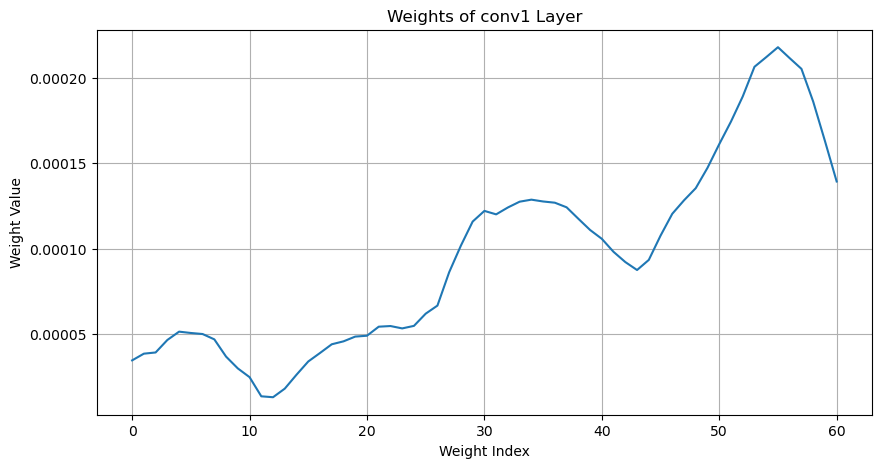

In [41]:
torch_debugger_inst._track_weights
'conv1.weight'
torch_debugger_inst.plot_weight_updates()

In [35]:
torch_debugger_inst._track_weights['conv1.weight']

dict(model_ft.named_parameters())['conv1.weight'].shape

torch.Size([64, 3, 7, 7])

In [42]:
# model_ft = 
# _ = 
# _WEIGHTS_UPDATED, _model_named_parameters, _torch_debugger_inst_initial_model_weights_state 
torch_debugger_inst, _model = \
    train_model(
    model_ft, 
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    num_epochs=25,
    debug_mode=True,
    granular_logging=True)

    >> Step 0 : Verifying optimizer

Optimizer State:

Parameter group 0:
Learning rate: 0.001
Parameters requiring gradient: 62
NULL_GRADIENTS:   True
avg_grads, layers: 
[0.011620492674410343] ['conv1.weight']
Epoch 0/24
----------

            -----------------------------------------------------------------------------
            Launching proc job: train
            -----------------------------------------------------------------------------
            


/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zachwolpe/miniforge3/envs/CDB/envs/pytorch-transfer-learning-debugger/lib/python3.9/lib-dynload/../

    >> Step 1 : Moving data to device
    >> Step 2 : Zeroing gradients
    >> Step 3 : Forward pass - get predictions class - compute loss
    >> Step 4 : Compute gradient - Optimizer take step
avg_grads, layers: 
[0.020298726856708527] ['conv1.weight']
NULL_GRADIENTS:   True
    >> Step 5 : Compute running statistics.
    >> Step 6 : Scheduler step.
EXIT RUN - GRANULAR DEBUGGING ACTIVE.
